Calculation of Implied Volatility

In [1]:
"""
name_df เก็บชื่อ stocks ไว้ทั้งหมดที่จะใช้ + ราคา S0, 

เหลือใส่ black scholes เทียยบราคาจาก vol forecast กับ ราคาจริง(จากimplied Vol)
ต้องใช้ S0 (ดึง tvdatafeed ได้)
Strike Price ย้อนสูตร black scholes
"""


'\nname_df เก็บชื่อ stocks ไว้ทั้งหมดที่จะใช้ + ราคา S0, \n\nเหลือใส่ black scholes เทียยบราคาจาก vol forecast กับ ราคาจริง(จากimplied Vol)\nต้องใช้ S0 (ดึง tvdatafeed ได้)\nStrike Price ย้อนสูตร black scholes\n'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#in case of dw01

import requests
from bs4 import BeautifulSoup
import pandas as pd
url = 'https://www.blswarrant.com/search'
head = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36'

print('0')

html = requests.get(url, headers={'User-Agent': head}).content
df_list = pd.read_html(html)
df_dw01 = df_list[2]
df_dw01['Stock']='SET:' + df_dw01['DW Symbol'].apply(lambda x: x[:-8])
name_df = pd.DataFrame(df_dw01['Stock'].drop_duplicates())
name_df.reset_index(inplace=True)
name_df = name_df.drop(['index'],axis=1)
name_df

0


,Stock
0,SET:DELTA
1,SET:BH
2,SET:VGI
3,SET:TOP
4,SET:SET50
...,...
77,SET:TLI
78,SET:TRUE
79,SET:TTB
80,SET:TU


In [4]:
df_dw01 = df_dw01.drop(['Effective Gearing','Sensitivity','Time Decay','Moneyness','Status','TTM (days)'],axis=1)
df_dw01

,DW Symbol,Imp.Vol.,Last Trading Date,Stock
0,DELTA01C2407B,83.99%,05 Jul 24,SET:DELTA
1,BH01C2408A,53.25%,07 Aug 24,SET:BH
2,DELTA01C2409A,79.83%,06 Sep 24,SET:DELTA
3,DELTA01P2408X,88.67%,07 Aug 24,SET:DELTA
4,VGI01P2408X,80.43%,07 Aug 24,SET:VGI
...,...,...,...,...
293,VGI01P2405X,74.66%,09 May 24,SET:VGI
294,WHA01C2405A,106.35%,09 May 24,SET:WHA
295,WHA01C2406A,54.39%,10 Jun 24,SET:WHA
296,WHA01C2408A,54.45%,07 Aug 24,SET:WHA


In [5]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

tv = TvDatafeed()
df = tv.get_hist(symbol='SET:SET50', exchange='SET', interval=Interval.in_daily, n_bars=1201)
set50 = df[['close']]
set50.rename(columns = {'close':'remove'}, inplace=True)


you are using nologin method, data you access may be limited


In [6]:
for i in range (name_df.shape[0]):
    df = tv.get_hist(symbol=name_df['Stock'][i], exchange='SET', interval=Interval.in_daily, n_bars=1201)
    df = df[['close']]
    set50 = pd.merge(set50, df, left_index=True, right_index=True, how='outer')
    set50.rename(columns = {'close':name_df['Stock'][i]}, inplace=True)
set50 = set50.drop('remove',axis=1)

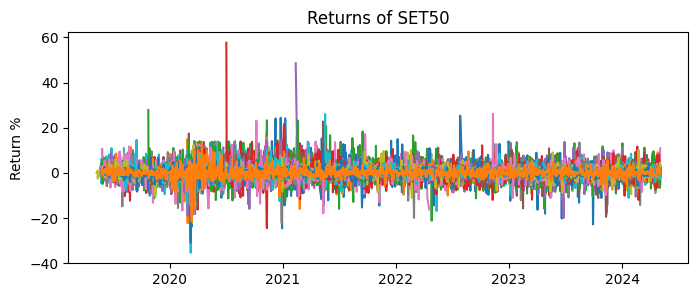

In [7]:
returns = np.log(set50).diff() * 100 #1st difference
plt.figure(figsize=(8,3))
plt.plot(returns)
plt.ylabel("Return %")
plt.title('Returns of SET50');

In [8]:
conclu = name_df[['Stock']]
conclu

,Stock
0,SET:DELTA
1,SET:BH
2,SET:VGI
3,SET:TOP
4,SET:SET50
...,...
77,SET:TLI
78,SET:TRUE
79,SET:TTB
80,SET:TU


In [9]:
from arch import arch_model
from sklearn.metrics import mean_squared_error
best_model_list = []
for i in range (name_df.shape[0]):

    returns_individual = returns[[name_df['Stock'][i]]]
    returns_individual = returns_individual.dropna()

    real_vol = []
    for i in range(len(returns)):
        vol = returns_individual[:i].std()
        real_vol.append(vol)

    len_test = int(0.2 * len(returns_individual))
    test_vol = real_vol[-len_test:]

    returns_train, returns_test= returns_individual[:-len_test], returns_individual[-len_test:]

    garch_model_fit = arch_model(returns_train,vol="Garch",p=1,q=1).fit(disp='off',update_freq=len(returns_test))
    arch_model_fit = arch_model(returns_train,vol="ARCH").fit(disp='off',update_freq=len(returns_test))
    gjr_garch_model_fit = arch_model(returns_train,p=1,o=1,q=1).fit(disp='off',update_freq=len(returns_test))
    harch_model_fit = arch_model(returns_train,vol='Harch').fit(disp='off',update_freq=len(returns_test))

    garch_forecast = garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    arch_forecast = arch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    gjr_garch_forecast = gjr_garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    harch_forecast = harch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)

    garch = garch_forecast.variance.values[-1,:].flatten()
    arch = arch_forecast.variance.values[-1,:].flatten()
    gjr = gjr_garch_forecast.variance.values[-1,:].flatten()
    harch = harch_forecast.variance.values[-1,:].flatten()

    df_test = returns_test.copy()
    df_test['garch']= np.sqrt(garch)
    df_test['arch']= np.sqrt(arch)
    df_test['gjr']= np.sqrt(gjr)
    df_test['harch']= np.sqrt(harch)
    df_test['Vol'] = np.array(test_vol)

    garch_mae = mean_squared_error(df_test['Vol'],df_test['garch'])
    arch_mae = mean_squared_error(df_test['Vol'],df_test['arch'])
    gjr_garch_mae = mean_squared_error(df_test['Vol'],df_test['gjr'])
    harch_mae = mean_squared_error(df_test['Vol'],df_test['harch'])
    mae = [garch_mae,arch_mae,gjr_garch_mae,harch_mae]
    best = mae.index(min(mae))

    if best == 0:
        mod = 'garch'
    elif best == 1:
        mod = 'arch'
    elif best == 2:
        mod = 'gjr'
    elif best == 3:
        mod = 'harch'
    best_model_list.append(mod)

conclu['Suggested Models'] = np.array(best_model_list)

In [10]:
#หาวันจริงๆ
import datetime
def days_to_maturity(maturity_date):
    maturity_date = datetime.datetime.strptime(maturity_date, "%d %b %y").date()
    today = datetime.date.today()
    days_left = (maturity_date - today).days
    return days_left
df_dw01['TTM'] = df_dw01['Last Trading Date'].apply(days_to_maturity)
df_dw01

,DW Symbol,Imp.Vol.,Last Trading Date,Stock,TTM
0,DELTA01C2407B,83.99%,05 Jul 24,SET:DELTA,63
1,BH01C2408A,53.25%,07 Aug 24,SET:BH,96
2,DELTA01C2409A,79.83%,06 Sep 24,SET:DELTA,126
3,DELTA01P2408X,88.67%,07 Aug 24,SET:DELTA,96
4,VGI01P2408X,80.43%,07 Aug 24,SET:VGI,96
...,...,...,...,...,...
293,VGI01P2405X,74.66%,09 May 24,SET:VGI,6
294,WHA01C2405A,106.35%,09 May 24,SET:WHA,6
295,WHA01C2406A,54.39%,10 Jun 24,SET:WHA,38
296,WHA01C2408A,54.45%,07 Aug 24,SET:WHA,96


In [11]:
volatility_list_g = []
volatility_list_a = []
volatility_list_gj = []
volatility_list_h = []
for i in range (len(df_dw01)):
    returns_individual = returns[[df_dw01['Stock'][i]]].dropna()
    forecast_model_fit_g = arch_model(returns_individual,vol="Garch", p=1,q=1).fit(disp='off')
    forecast_model_fit_a = arch_model(returns_individual,vol="ARCH").fit(disp='off')
    forecast_model_fit_gj = arch_model(returns_individual,p=1,o=1,q=1).fit(disp='off')
    forecast_model_fit_h = arch_model(returns_individual,vol="Harch").fit(disp='off')
    forecast_g = forecast_model_fit_g.forecast(horizon=df_dw01['TTM'][i],method='analytic',reindex=True)
    forecast_a = forecast_model_fit_a.forecast(horizon=df_dw01['TTM'][i],method='analytic',reindex=True)
    forecast_gj = forecast_model_fit_gj.forecast(horizon=df_dw01['TTM'][i],method='analytic',reindex=True)
    forecast_h = forecast_model_fit_h.forecast(horizon=df_dw01['TTM'][i],method='analytic',reindex=True)
    
    y = forecast_g.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_g.append(vol6m)

    y = forecast_a.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_a.append(vol6m)

    y = forecast_gj.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_gj.append(vol6m)

    y = forecast_h.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_h.append(vol6m)
    
df_dw01['Vol_Garch'] = np.array(volatility_list_g)
df_dw01['Vol_Arch'] = np.array(volatility_list_a)
df_dw01['Vol_GJR'] = np.array(volatility_list_gj)
df_dw01['Vol_Harch'] = np.array(volatility_list_h)

In [12]:
summary = pd.merge(df_dw01,conclu,on='Stock')
result = []
for i in range(len(summary)):
    if summary['Suggested Models'][i] == 'garch':
        result.append(summary['Vol_Garch'][i])
    elif summary['Suggested Models'][i] == 'arch':
        result.append(summary['Vol_Arch'][i])
    elif summary['Suggested Models'][i] == 'gjr':
        result.append(summary['Vol_GJR'][i])
    elif summary['Suggested Models'][i] == 'harch':
        result.append(summary['Vol_Harch'][i])

summary['Suggested Model Results'] = np.array(result)
summary['Imp.Vol.'] = summary['Imp.Vol.'].apply(lambda x:x[:-1]).astype(float)

summary['Imp.Vol. - Forecasted Vol.'] = summary['Imp.Vol.'] - summary['Suggested Model Results']
summary


,DW Symbol,Imp.Vol.,Last Trading Date,Stock,TTM,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.
0,DELTA01C2407B,83.99,05 Jul 24,SET:DELTA,63,69.536165,71.136127,67.310935,71.135810,garch,69.536165,14.453835
1,BH01C2408A,53.25,07 Aug 24,SET:BH,96,31.039154,30.179325,31.018365,30.179292,arch,30.179325,23.070675
2,DELTA01C2409A,79.83,06 Sep 24,SET:DELTA,126,69.539481,71.136127,67.383398,71.135810,garch,69.539481,10.290519
3,DELTA01P2408X,88.67,07 Aug 24,SET:DELTA,96,69.539440,71.136127,67.379009,71.135810,garch,69.539440,19.130560
4,VGI01P2408X,80.43,07 Aug 24,SET:VGI,96,44.086281,41.120133,43.375843,41.120197,harch,41.120197,39.309803
...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,74.66,09 May 24,SET:VGI,6,47.177148,41.120117,41.723249,41.120180,harch,41.120180,33.539820
294,WHA01C2405A,106.35,09 May 24,SET:WHA,6,24.398490,34.326472,23.098750,34.326761,arch,34.326472,72.023528
295,WHA01C2406A,54.39,10 Jun 24,SET:WHA,38,27.345897,34.340298,26.220335,34.340593,arch,34.340298,20.049702
296,WHA01C2408A,54.45,07 Aug 24,SET:WHA,96,30.229362,34.340298,29.173502,34.340593,arch,34.340298,20.109702


In [13]:
#  ต้องเข้าลิงค์แต่ละอันไปเอา strike price https://www.blswarrant.com/mydw/'ชื่อdw'
# หาw,jw
import re
strike = []
ratio = []
for i in range(len(summary)):
    url = 'https://www.blswarrant.com/mydw/' + summary['DW Symbol'][i]
    html = requests.get(url, headers={'User-Agent': head}).content
    soup = BeautifulSoup(html, 'html.parser')
    all_text = soup.get_text()
    pattern = r"Strike \(THB\)\n:\s*([\d,]+\.\d+)"
    match = re.search(pattern, all_text)
    strike_price = match.group(1)
    strike.append(strike_price)

    pattern = r"Ratio \(DW:Underlying\)\n:\s*([\d,]+\.\d+)"
    match = re.search(pattern, all_text)
    rat = match.group(1)
    ratio.append(rat)
summary['Strike'] = np.array(strike)
summary['Ratio'] = np.array(ratio)
summary

,DW Symbol,Imp.Vol.,Last Trading Date,Stock,TTM,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,Ratio
0,DELTA01C2407B,83.99,05 Jul 24,SET:DELTA,63,69.536165,71.136127,67.310935,71.135810,garch,69.536165,14.453835,96.500,8.40205
1,BH01C2408A,53.25,07 Aug 24,SET:BH,96,31.039154,30.179325,31.018365,30.179292,arch,30.179325,23.070675,280.076,37.09199
2,DELTA01C2409A,79.83,06 Sep 24,SET:DELTA,126,69.539481,71.136127,67.383398,71.135810,garch,69.539481,10.290519,102.000,9.23042
3,DELTA01P2408X,88.67,07 Aug 24,SET:DELTA,96,69.539440,71.136127,67.379009,71.135810,garch,69.539440,19.130560,48.500,4.27873
4,VGI01P2408X,80.43,07 Aug 24,SET:VGI,96,44.086281,41.120133,43.375843,41.120197,harch,41.120197,39.309803,1.290,0.22261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,74.66,09 May 24,SET:VGI,6,47.177148,41.120117,41.723249,41.120180,harch,41.120180,33.539820,1.660,0.42023
294,WHA01C2405A,106.35,09 May 24,SET:WHA,6,24.398490,34.326472,23.098750,34.326761,arch,34.326472,72.023528,6.350,1.82044
295,WHA01C2406A,54.39,10 Jun 24,SET:WHA,38,27.345897,34.340298,26.220335,34.340593,arch,34.340298,20.049702,6.150,0.64256
296,WHA01C2408A,54.45,07 Aug 24,SET:WHA,96,30.229362,34.340298,29.173502,34.340593,arch,34.340298,20.109702,5.600,0.87392


In [14]:
#ตอนนมี Vol, K,t,  ขาด S0, C,P , rrf
#S0
Spot = []
df_spot = name_df.copy()
for i in range(len(conclu)):
    df = tv.get_hist(symbol=name_df['Stock'][i], exchange='SET', interval=Interval.in_daily, n_bars=2)
    s = df['close'][-1]
    Spot.append(s)
df_spot['S'] = np.array(Spot)
summary = pd.merge(summary,df_spot,on='Stock')
summary

,DW Symbol,Imp.Vol.,Last Trading Date,Stock,TTM,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,Ratio,S
0,DELTA01C2407B,83.99,05 Jul 24,SET:DELTA,63,69.536165,71.136127,67.310935,71.135810,garch,69.536165,14.453835,96.500,8.40205,70.00
1,BH01C2408A,53.25,07 Aug 24,SET:BH,96,31.039154,30.179325,31.018365,30.179292,arch,30.179325,23.070675,280.076,37.09199,252.00
2,DELTA01C2409A,79.83,06 Sep 24,SET:DELTA,126,69.539481,71.136127,67.383398,71.135810,garch,69.539481,10.290519,102.000,9.23042,70.00
3,DELTA01P2408X,88.67,07 Aug 24,SET:DELTA,96,69.539440,71.136127,67.379009,71.135810,garch,69.539440,19.130560,48.500,4.27873,70.00
4,VGI01P2408X,80.43,07 Aug 24,SET:VGI,96,44.086281,41.120133,43.375843,41.120197,harch,41.120197,39.309803,1.290,0.22261,1.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,74.66,09 May 24,SET:VGI,6,47.177148,41.120117,41.723249,41.120180,harch,41.120180,33.539820,1.660,0.42023,1.81
294,WHA01C2405A,106.35,09 May 24,SET:WHA,6,24.398490,34.326472,23.098750,34.326761,arch,34.326472,72.023528,6.350,1.82044,5.10
295,WHA01C2406A,54.39,10 Jun 24,SET:WHA,38,27.345897,34.340298,26.220335,34.340593,arch,34.340298,20.049702,6.150,0.64256,5.10
296,WHA01C2408A,54.45,07 Aug 24,SET:WHA,96,30.229362,34.340298,29.173502,34.340593,arch,34.340298,20.109702,5.600,0.87392,5.10


In [15]:
#c,p
cp_list = []
for i in range(len(summary)):
    df = tv.get_hist(symbol='SET:' + summary['DW Symbol'][i], exchange='SET', interval=Interval.in_daily, n_bars=2)
    cp = df['close'][-1]
    cp_list.append(cp)
summary['Call/Put'] = np.array(cp_list)
summary

,DW Symbol,Imp.Vol.,Last Trading Date,Stock,TTM,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,Ratio,S,Call/Put
0,DELTA01C2407B,83.99,05 Jul 24,SET:DELTA,63,69.536165,71.136127,67.310935,71.135810,garch,69.536165,14.453835,96.500,8.40205,70.00,0.34
1,BH01C2408A,53.25,07 Aug 24,SET:BH,96,31.039154,30.179325,31.018365,30.179292,arch,30.179325,23.070675,280.076,37.09199,252.00,0.46
2,DELTA01C2409A,79.83,06 Sep 24,SET:DELTA,126,69.539481,71.136127,67.383398,71.135810,garch,69.539481,10.290519,102.000,9.23042,70.00,0.52
3,DELTA01P2408X,88.67,07 Aug 24,SET:DELTA,96,69.539440,71.136127,67.379009,71.135810,garch,69.539440,19.130560,48.500,4.27873,70.00,0.72
4,VGI01P2408X,80.43,07 Aug 24,SET:VGI,96,44.086281,41.120133,43.375843,41.120197,harch,41.120197,39.309803,1.290,0.22261,1.81,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,74.66,09 May 24,SET:VGI,6,47.177148,41.120117,41.723249,41.120180,harch,41.120180,33.539820,1.660,0.42023,1.81,0.03
294,WHA01C2405A,106.35,09 May 24,SET:WHA,6,24.398490,34.326472,23.098750,34.326761,arch,34.326472,72.023528,6.350,1.82044,5.10,0.01
295,WHA01C2406A,54.39,10 Jun 24,SET:WHA,38,27.345897,34.340298,26.220335,34.340593,arch,34.340298,20.049702,6.150,0.64256,5.10,0.12
296,WHA01C2408A,54.45,07 Aug 24,SET:WHA,96,30.229362,34.340298,29.173502,34.340593,arch,34.340298,20.109702,5.600,0.87392,5.10,0.44


In [16]:

rf = tv.get_hist(symbol='ECONOMICS:THINTR', exchange='Central Bank',interval=Interval.in_monthly,n_bars=2)
rrf = rf['close'][-1]
rrf = rrf/100


In [17]:
summary['Ratio'] = summary['Ratio'].str.replace(',', '').astype(float)
summary['Strike'] = summary['Strike'].str.replace(',', '').astype(float)

In [18]:
#ลองกับ imp vol เช็คว่าค่าดหมือนหรือใกล้ค่าจริงมั้ย
from scipy.stats import norm
cp_f = []
summary['type'] = summary['DW Symbol'].apply(lambda x: x[-6])
for i in range(len(summary)): #put or call
    d1 = (np.log(summary['S'][i]/summary['Strike'][i]) + ((rrf + (((summary['Imp.Vol.'][i]/100)**2)/2))*(summary['TTM'][i]/365)))/((summary['Imp.Vol.'][i]/100) * np.sqrt(summary['TTM'][i]/365))
    d2 = d1 - ((summary['Imp.Vol.'][i]/100) * np.sqrt(summary['TTM'][i]/365))
    if summary['type'][i] == 'C':
        y = (summary['S'][i] * norm.cdf(d1)) - (summary['Strike'][i] * np.exp(-rrf * (summary['TTM'][i] / 365)) * norm.cdf(d2))
    elif summary['type'][i] == 'P':
        y = (summary['Strike'][i] * np.exp(-rrf * (summary['TTM'][i] / 365)) * norm.cdf(-d2)) - (summary['S'][i] * norm.cdf(-d1))
    y = y / summary['Ratio'][i]
    cp_f.append(y)
summary['Calculated Call/Put'] = np.array(cp_f)
summary

,DW Symbol,Imp.Vol.,Last Trading Date,Stock,TTM,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,Ratio,S,Call/Put,type,Calculated Call/Put
0,DELTA01C2407B,83.99,05 Jul 24,SET:DELTA,63,69.536165,71.136127,67.310935,71.135810,garch,69.536165,14.453835,96.500,8.40205,70.00,0.34,C,0.334128
1,BH01C2408A,53.25,07 Aug 24,SET:BH,96,31.039154,30.179325,31.018365,30.179292,arch,30.179325,23.070675,280.076,37.09199,252.00,0.46,C,0.472738
2,DELTA01C2409A,79.83,06 Sep 24,SET:DELTA,126,69.539481,71.136127,67.383398,71.135810,garch,69.539481,10.290519,102.000,9.23042,70.00,0.52,C,0.519882
3,DELTA01P2408X,88.67,07 Aug 24,SET:DELTA,96,69.539440,71.136127,67.379009,71.135810,garch,69.539440,19.130560,48.500,4.27873,70.00,0.72,P,0.703534
4,VGI01P2408X,80.43,07 Aug 24,SET:VGI,96,44.086281,41.120133,43.375843,41.120197,harch,41.120197,39.309803,1.290,0.22261,1.81,0.32,P,0.313637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,74.66,09 May 24,SET:VGI,6,47.177148,41.120117,41.723249,41.120180,harch,41.120180,33.539820,1.660,0.42023,1.81,0.03,P,0.039038
294,WHA01C2405A,106.35,09 May 24,SET:WHA,6,24.398490,34.326472,23.098750,34.326761,arch,34.326472,72.023528,6.350,1.82044,5.10,0.01,C,0.009779
295,WHA01C2406A,54.39,10 Jun 24,SET:WHA,38,27.345897,34.340298,26.220335,34.340593,arch,34.340298,20.049702,6.150,0.64256,5.10,0.12,C,0.114890
296,WHA01C2408A,54.45,07 Aug 24,SET:WHA,96,30.229362,34.340298,29.173502,34.340593,arch,34.340298,20.109702,5.600,0.87392,5.10,0.44,C,0.444723


In [19]:
#Black Scholes
from scipy.stats import norm
cp_f = []
summary['type'] = summary['DW Symbol'].apply(lambda x: x[-6])
for i in range(len(summary)): #put or call
    d1 = (np.log(summary['S'][i]/summary['Strike'][i]) + ((rrf + (((summary['Suggested Model Results'][i]/100)**2)/2))*(summary['TTM'][i]/365)))/((summary['Suggested Model Results'][i]/100) * np.sqrt(summary['TTM'][i]/365))
    d2 = d1 - ((summary['Suggested Model Results'][i]/100) * np.sqrt(summary['TTM'][i]/365))
    if summary['type'][i] == 'C':
        y = (summary['S'][i] * norm.cdf(d1)) - (summary['Strike'][i] * np.exp(-rrf * (summary['TTM'][i] / 365)) * norm.cdf(d2))
    elif summary['type'][i] == 'P':
        y = (summary['Strike'][i] * np.exp(-rrf * (summary['TTM'][i] / 365)) * norm.cdf(-d2)) - (summary['S'][i] * norm.cdf(-d1))
    y = y / summary['Ratio'][i]
    cp_f.append(y)
summary['Calculated Call/Put'] = np.array(cp_f)
summary

,DW Symbol,Imp.Vol.,Last Trading Date,Stock,TTM,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,Ratio,S,Call/Put,type,Calculated Call/Put
0,DELTA01C2407B,83.99,05 Jul 24,SET:DELTA,63,69.536165,71.136127,67.310935,71.135810,garch,69.536165,14.453835,96.500,8.40205,70.00,0.34,C,1.935628e-01
1,BH01C2408A,53.25,07 Aug 24,SET:BH,96,31.039154,30.179325,31.018365,30.179292,arch,30.179325,23.070675,280.076,37.09199,252.00,0.46,C,1.742514e-01
2,DELTA01C2409A,79.83,06 Sep 24,SET:DELTA,126,69.539481,71.136127,67.383398,71.135810,garch,69.539481,10.290519,102.000,9.23042,70.00,0.52,C,3.690496e-01
3,DELTA01P2408X,88.67,07 Aug 24,SET:DELTA,96,69.539440,71.136127,67.379009,71.135810,garch,69.539440,19.130560,48.500,4.27873,70.00,0.72,P,3.644957e-01
4,VGI01P2408X,80.43,07 Aug 24,SET:VGI,96,44.086281,41.120133,43.375843,41.120197,harch,41.120197,39.309803,1.290,0.22261,1.81,0.32,P,3.057437e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,74.66,09 May 24,SET:VGI,6,47.177148,41.120117,41.723249,41.120180,harch,41.120180,33.539820,1.660,0.42023,1.81,0.03,P,4.499963e-03
294,WHA01C2405A,106.35,09 May 24,SET:WHA,6,24.398490,34.326472,23.098750,34.326761,arch,34.326472,72.023528,6.350,1.82044,5.10,0.01,C,8.558419e-09
295,WHA01C2406A,54.39,10 Jun 24,SET:WHA,38,27.345897,34.340298,26.220335,34.340593,arch,34.340298,20.049702,6.150,0.64256,5.10,0.12,C,1.912619e-02
296,WHA01C2408A,54.45,07 Aug 24,SET:WHA,96,30.229362,34.340298,29.173502,34.340593,arch,34.340298,20.109702,5.600,0.87392,5.10,0.44,C,2.139861e-01


In [20]:
#Difference
summary['diff'] = summary['Call/Put'] - summary['Calculated Call/Put']
summary

,DW Symbol,Imp.Vol.,Last Trading Date,Stock,TTM,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,Ratio,S,Call/Put,type,Calculated Call/Put,diff
0,DELTA01C2407B,83.99,05 Jul 24,SET:DELTA,63,69.536165,71.136127,67.310935,71.135810,garch,69.536165,14.453835,96.500,8.40205,70.00,0.34,C,1.935628e-01,0.146437
1,BH01C2408A,53.25,07 Aug 24,SET:BH,96,31.039154,30.179325,31.018365,30.179292,arch,30.179325,23.070675,280.076,37.09199,252.00,0.46,C,1.742514e-01,0.285749
2,DELTA01C2409A,79.83,06 Sep 24,SET:DELTA,126,69.539481,71.136127,67.383398,71.135810,garch,69.539481,10.290519,102.000,9.23042,70.00,0.52,C,3.690496e-01,0.150950
3,DELTA01P2408X,88.67,07 Aug 24,SET:DELTA,96,69.539440,71.136127,67.379009,71.135810,garch,69.539440,19.130560,48.500,4.27873,70.00,0.72,P,3.644957e-01,0.355504
4,VGI01P2408X,80.43,07 Aug 24,SET:VGI,96,44.086281,41.120133,43.375843,41.120197,harch,41.120197,39.309803,1.290,0.22261,1.81,0.32,P,3.057437e-02,0.289426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,74.66,09 May 24,SET:VGI,6,47.177148,41.120117,41.723249,41.120180,harch,41.120180,33.539820,1.660,0.42023,1.81,0.03,P,4.499963e-03,0.025500
294,WHA01C2405A,106.35,09 May 24,SET:WHA,6,24.398490,34.326472,23.098750,34.326761,arch,34.326472,72.023528,6.350,1.82044,5.10,0.01,C,8.558419e-09,0.010000
295,WHA01C2406A,54.39,10 Jun 24,SET:WHA,38,27.345897,34.340298,26.220335,34.340593,arch,34.340298,20.049702,6.150,0.64256,5.10,0.12,C,1.912619e-02,0.100874
296,WHA01C2408A,54.45,07 Aug 24,SET:WHA,96,30.229362,34.340298,29.173502,34.340593,arch,34.340298,20.109702,5.600,0.87392,5.10,0.44,C,2.139861e-01,0.226014


In [21]:
opp = []
for i in range(len(summary)):
    if summary['diff'][i] > 0:
        g = 'Overpriced'
    else:
        g = 'Underpriced'
    opp.append(g)
summary['Arbitrage'] = np.array(opp)

In [22]:
summary.to_excel('Summary.xlsx')